Define headers

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Define Dataset

In [2]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image

def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
#         print(filename)
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

Confirm if datasets works

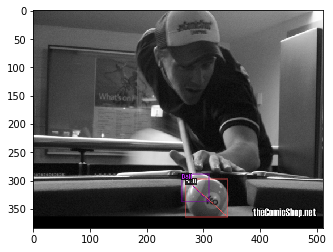

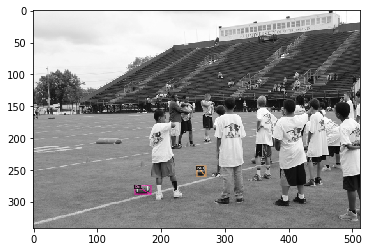

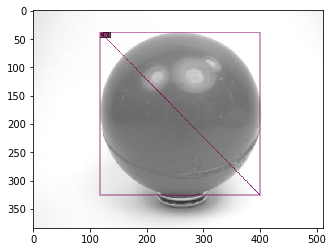

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")
# print (dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch
torch.cuda.set_device(2)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[01/24 10:05:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/24 10:05:05 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[01/24 10:05:05 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/24 10:05:05 d2.data.build]: Using training sampler TrainingSampler
[01/24 10:05:05 d2.engine.train_loop]: Starting training from iteration 2000
[01/24 10:05:05 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


OrderedDict()

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

tensor([], device='cuda:2') Boxes(tensor([], device='cuda:2', size=(0, 4)))


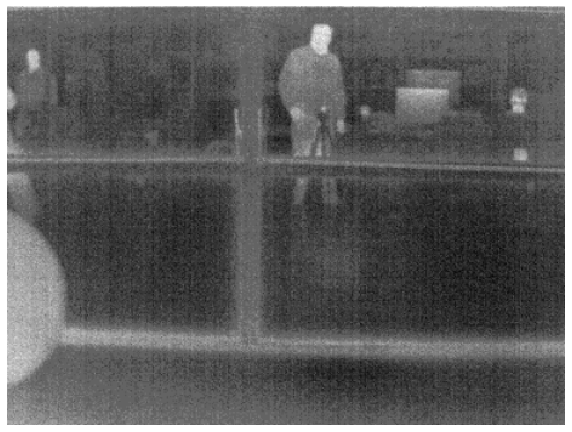

In [8]:
im = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/thermic/1579790238028925357.png")

outputs = predictor(im)
print(outputs["instances"].scores, outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

results=outputs["instances"].to("cpu")
# results.pred_boxes.tensor[0].numpy()

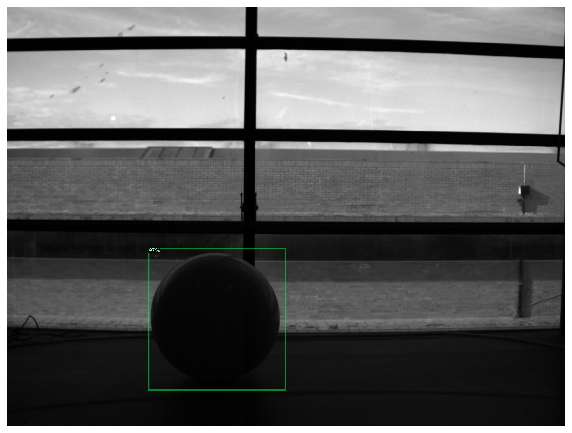

In [9]:
im_rgb = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/RGB/1579790235832626993.png")

outputs2 = predictor(im_rgb)

v = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

In [ ]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
from detectron2.utils.visualizer import ColorMode
import numpy as np
import time

d_real=0.63 *1000#m

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

In [ ]:

cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])

print(cameraMatrix_RGB)

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

In [ ]:
txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
f = open(txt_file, "r")
txt_result = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_ir.txt"),"w") 
centers=diameters=[]


for line in f: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im = cv2.imread(line[:88])
    outputs = predictor(im)
    
    results=outputs["instances"].to("cpu")


# UNCOMENT TO VISUALIZE IMAGES
#     v= Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(results)
#     plt.figure()
#     plt.imshow(v.get_image()[:, :, ::-1])
#     print(results.scores,results.pred_boxes)

# CALCULATE CENTERS
    if(len(results)!=0 and results.scores.numpy()[0]>0.85):
        
        coordinates=results.pred_boxes.tensor[0].numpy()
#         print(coordinates)
        xc=(coordinates[0]+coordinates[2])/2+coordinates[0]
        yc=(coordinates[3]+coordinates[1])/2+coordinates[1]
        xc=float("%0.2f"%xc)
        yc=float("%0.2f"%yc)
        centers.append([xc,yc])
        
        dx=float("%0.2f"%(float("%0.2f"%coordinates[2])-float("%0.2f"%coordinates[0])))
        dy=float("%0.2f"%(float("%0.2f"%coordinates[3])-float("%0.2f"%coordinates[1])))
        d_pix=(dx+dy)/2
        diameters.append([dx,dy]) 
        
        Z=((fx+fy)/2)*(d_real/d_pix)
        X=(Z*(xc-cx))/fx
        Y=(Z*(yc-cy))/fy
        
        
        txt_result.write(line[:88])
        txt_result.write(" , ")
        txt_result.write(np.array2string(coordinates))
        txt_result.write("\n")
        print(X/1000,Y/1000,Z/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result.close()
f.close()

    

In [ ]:
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")
f_rgb = open(txt_file_rgb, "r")
txt_result_rgb = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_rgb.txt"),"w") 
centers_rgb=diameters_rgb=[]

_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

for line_rgb in f_rgb: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im_rgb = cv2.imread(line_rgb[:84])
#     plt.imshow(im_rgb)
    outputs_rgb = predictor(im_rgb)


# GET BOUNDING BOXES
    results_rgb=outputs_rgb["instances"].to("cpu")
    
# UNCOMENT TO VISUALIZE IMAGES    
#     v_rgb = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v_rgb = v_rgb.draw_instance_predictions(results_rgb)
#     plt.figure()
#     plt.imshow(v_rgb.get_image()[:, :, ::-1])
    
# CALCULATE CENTERS    
    if(len(results_rgb)!=0):
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        xc_rgb=(coordinates_rgb[0]+coordinates_rgb[2])/2+coordinates_rgb[0]
        yc_rgb=(coordinates_rgb[3]+coordinates_rgb[1])/2+coordinates_rgb[1]
        xc_rgb=float("%0.2f"%xc_rgb)
        yc_rgb=float("%0.2f"%yc_rgb)
        centers_rgb.append([xc_rgb,yc_rgb])
        
        dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
        dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
        d_pix_rgb=(dx_rgb+dy_rgb)/2
        diameters_rgb.append([dx_rgb,dy_rgb]) 
        
        Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
        X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
        Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb
        
        
        txt_result_rgb.write(line_rgb[:88])
        txt_result_rgb.write(" , ")
        txt_result_rgb.write(np.array2string(coordinates_rgb))
        txt_result_rgb.write("\n")
        print(X_rgb/1000,Y_rgb/1000,Z_rgb/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result_rgb.close()
f_rgb.close()



In [20]:
import pcl

ImportError: libpcl_keypoints.so.1.7: cannot open shared object file: No such file or directory